■ 아래 과정을 통해 로드된 data는 영화, 드라마, 배우, 게임 등에 관한 정보를 제공하는 온라인 데이터베이스인 imdb의 영화 리뷰 데이터이다. **train_sequences와 test_sequences는 tokenize를 통해 text를 정수로 변환한 결과**이며, **train_labels와 test_labels는 대응되는 sequences가 긍정 또는 부정 리뷰를 의미하는 0 또는 1 값**을 가지는 데이터이다.
- tokenizer는 500개의 text를 정수로 변환하였다. (**vocabulary size는 500**이다.) 
- **양방향(Bidirectional) LSTM** 기반의 model을 생성하고 주어진 **train_sequences을 model 입력에 적절한 형태로 변형한 data와 train_labels**로 학습하시오.
- **문장의 최대 길이, Embedding layer를 통과한 data의 dimension과 LSTM node의 수 등은 자유롭게 선정**하시오.
- **test 데이터**에 대한 결과를 통해 **성능을 평가**하시오.
- <strong><font color='red' style='bold'>주석을 이용하여 각 과정의 역할과 변수의 의미를 상세히 서술하시오.</font></strong>

In [1]:
import numpy as np

imdb = np.load('imdb.npz',allow_pickle=True)
train_sequences = imdb['arr_0']
train_labels = imdb['arr_1']
test_sequences = imdb['arr_2']
test_labels = imdb['arr_3']

In [2]:
import json
import urllib

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Flatten,Embedding,LSTM,Bidirectional
from tensorflow.keras.models import Sequential

In [4]:
print(imdb)

In [14]:
vocab_size = 500
oov = '<OOV>'

token = Tokenizer(num_words=vocab_size,oov_token=oov)

In [21]:
# train_sequences와 test_sequences는 tokenize를 통해 text를 정수로 변환한 결과
# tokenize 과정 생략
print(train_sequences[10])

[1, 2, 189, 438, 47, 110, 142, 7, 6, 2, 120, 4, 236, 378, 7, 153, 19, 87, 108, 141, 17, 2, 5, 2, 2, 2, 23, 8, 4, 136, 2, 2, 4, 2, 43, 2, 21, 2, 419, 5, 2, 120, 91, 2, 189, 2, 5, 9, 2, 31, 7, 4, 118, 2, 189, 108, 126, 93, 2, 16, 2, 324, 23, 6, 364, 352, 21, 14, 9, 93, 56, 18, 11, 230, 53, 2, 74, 31, 34, 4, 2, 7, 4, 22, 5, 14, 11, 471, 9, 2, 34, 4, 321, 487, 5, 116, 15, 2, 4, 22, 9, 6, 2, 4, 114, 2, 23, 107, 293, 2, 2, 5, 328, 2, 4, 2, 109, 9, 6, 132, 2, 2, 2, 8, 2, 18, 2, 29, 9, 276, 11, 6, 2, 19, 289, 409, 4, 2, 2, 2, 2, 2, 2, 2, 5, 27, 2, 2, 2, 103, 6, 346, 137, 11, 4, 2, 295, 36, 2, 2, 6, 2, 273, 11, 4, 2, 15, 2, 35, 154, 2, 103, 2, 173, 7, 12, 36, 2, 2, 94, 2, 2, 5, 2, 36, 203, 30, 2, 8, 361, 12, 8, 2, 143, 4, 2, 2, 10, 10, 328, 2, 9, 6, 55, 221, 2, 5, 146, 165, 179, 2, 15, 50, 2, 53, 108, 448, 23, 12, 17, 225, 38, 76, 2, 18, 183, 8, 81, 19, 12, 45, 2, 8, 135, 15, 2, 166, 4, 118, 7, 45, 2, 17, 466, 45, 2, 4, 22, 115, 165, 2, 2, 5, 2, 8, 2, 73, 469, 167, 2, 2, 2, 6, 87, 2, 18, 4, 22,

In [23]:
# 길이 출력

print(len((train_sequences[10])))

450


In [24]:
sen_len = 20
train_pad = pad_sequences(train_sequences,maxlen=sen_len,
                          truncating='post',padding='post')
test_pad = pad_sequences(test_sequences,maxlen=sen_len,
                         truncating='post',padding='post')

In [25]:
print(train_pad[10])
print(type(train_pad))

[  1   2 189 438  47 110 142   7   6   2 120   4 236 378   7 153  19  87
 108 141]
<class 'numpy.ndarray'>


In [26]:
train_y = np.array(train_labels)
test_y= np.array(test_labels)

In [27]:
emb_len = 16
emb = Embedding(input_dim=vocab_size,output_dim=emb_len,input_length=sen_len)

In [28]:
print(train_pad[20])
print(emb(train_pad[20])[0])

[  1   2  11   2  17   2  14   2  78  20   9  38  78  15  25 413   2   5
  28   8]
tf.Tensor(
[ 0.02103451 -0.04987377  0.02560497 -0.04413895  0.00321225  0.03465811
 -0.03201197  0.03006938  0.00541227  0.04335085 -0.00767789 -0.01658257
  0.01846156  0.03015509 -0.03027681 -0.00879005], shape=(16,), dtype=float32)


In [29]:
NLP_model = Sequential([
    # 첫 번째 layer는 embedding layer
    emb,
    # LSTM
    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(64)),
    # MLP
    Dense(32,activation='relu'),
    Dense(1,activation='sigmoid')
    # binary classification의 경우, output layer의 node를 1로 설정할 수 있음
])

In [30]:
NLP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 16)            8000      
                                                                 
 bidirectional (Bidirection  (None, 20, 128)           41472     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 152449 (595.50 KB)
Trainable params: 15244

In [31]:
NLP_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [32]:
type(train_labels)

numpy.ndarray

In [33]:
result = NLP_model.fit(train_pad,train_y,
                       epochs=10,batch_size=32,
                       validation_split=0.3)

Epoch 1/10


110/110 [==============================] - 7s 21ms/step - loss: 0.6912 - acc: 0.5126 - val_loss: 0.7106 - val_acc: 0.5407
Epoch 2/10
110/110 [==============================] - 1s 10ms/step - loss: 0.6360 - acc: 0.6366 - val_loss: 0.6485 - val_acc: 0.6047
Epoch 3/10
110/110 [==============================] - 1s 10ms/step - loss: 0.5824 - acc: 0.6920 - val_loss: 0.6452 - val_acc: 0.6073
Epoch 4/10
110/110 [==============================] - 1s 10ms/step - loss: 0.5525 - acc: 0.7166 - val_loss: 0.6692 - val_acc: 0.6080
Epoch 5/10
110/110 [==============================] - 1s 10ms/step - loss: 0.5323 - acc: 0.7417 - val_loss: 0.6689 - val_acc: 0.5960
Epoch 6/10
110/110 [==============================] - 1s 10ms/step - loss: 0.5165 - acc: 0.7469 - val_loss: 0.6816 - val_acc: 0.5960
Epoch 7/10
110/110 [==============================] - 1s 10ms/step - loss: 0.4963 - acc: 0.7626 - val_loss: 0.7274 - val_acc: 0.5973
Epoch 8/10
110/110 [==============================] - 1s 10ms/step 

In [34]:
# 성능 평가

NLP_model.evaluate(test_pad,test_y)

32/32 [==============================] - 0s 4ms/step - loss: 0.8679 - acc: 0.5960


[0.8679298758506775, 0.5960000157356262]

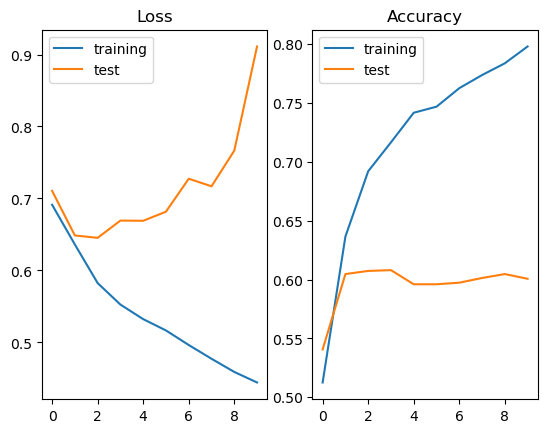

In [35]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.plot(result.history['loss'],label='training')
plt.plot(result.history['val_loss'],label='test')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(result.history['acc'],label='training')
plt.plot(result.history['val_acc'],label='test')
plt.title('Accuracy')
plt.legend()